<a href="https://colab.research.google.com/github/tdack21/cosmologia_ml/blob/main/Tarea_9_cosmoml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 9. Cosmología con Machine Learning
Tonatiuh Sánchez Madrid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [70]:
H0 = 68  # Hubble constant in km/s/Mpc
Omega_m0 = 0.3  # Matter density parameter
Omega_L0 = 0.7  # Dark energy density parameter

# CPL parameterization for w(z)
def w(z, w0, wa):
    return w0 + wa * (z / (1 + z))

# Hubble parameter function E(z) for CPL
def E(z, w0, wa):
    return np.sqrt(Omega_m0 * (1 + z)**3 + Omega_L0 * (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z)))

# Theoretical H(z)
def H(z, w0, wa):
    return H0 * E(z, w0, wa)

# Observational data (H(z) from Cosmic Chronometers)
z_H = np.array([0.07, 0.12, 0.20, 0.28, 0.40, 0.50, 0.60, 0.80, 1.00])
H_obs = np.array([69, 68.6, 72.9, 88.8, 95, 97, 87.9, 117, 168])  # H(z) values in km/s/Mpc
H_err = np.array([19.6, 26.2, 29.6, 36.6, 17, 62, 6.1, 23.4, 17.4])  # Errors

# Chi-squared function
def chi2(w0, wa):
    H_theo = np.array([H(zi, w0, wa) for zi in z_H])
    return np.sum(((H_obs - H_theo) / H_err)**2)

# Generate a grid of w0 and wa values
w0_values = np.linspace(-7, 0, 50)
wa_values = np.linspace(-4, 20, 50)
w0_grid, wa_grid = np.meshgrid(w0_values, wa_values)

# Calculate chi2 for each combination of w0 and wa
chi2_grid = np.array([[chi2(w0, wa) for w0 in w0_values] for wa in wa_values])

# Calculate likelihood
likelihood_grid = np.exp(-0.5 * chi2_grid)

# Flatten the grids and sort by likelihood
w0_flat = w0_grid.flatten()
wa_flat = wa_grid.flatten()
likelihood_flat = likelihood_grid.flatten()

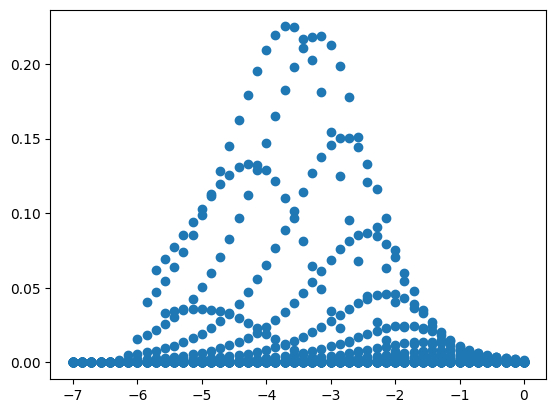

In [73]:
plt.scatter(w0_flat, likelihood_flat)

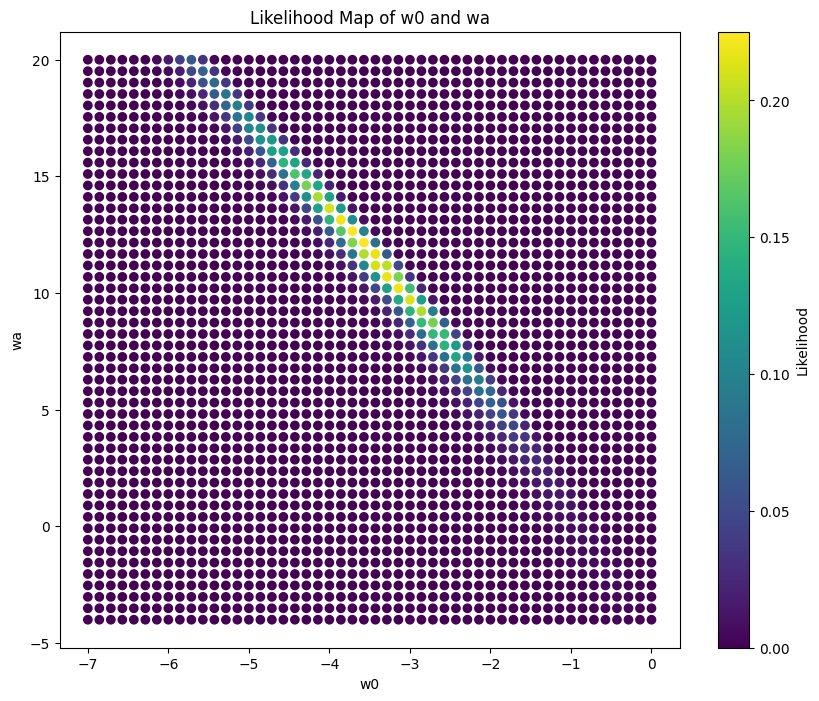

In [74]:
plt.figure(figsize=(10, 8))
plt.scatter(w0_flat, wa_flat, c=likelihood_flat, cmap='viridis')
plt.xlabel('w0')
plt.ylabel('wa')
plt.colorbar(label='Likelihood')
plt.title('Likelihood Map of w0 and wa')
plt.show()


In [75]:
# Función de likelihood
def likelihood(w0, wa):
    return np.exp(-0.5 * chi2(w0, wa))  # Ejemplo basado en chi2

# Función de fitness
def _fitness(x):
    w0, wa = x  # Desempaquetar los valores de w0 y wa
    if -7 < w0 < 0 and -5 < wa < 20:  # Restricciones en w0 y wa
        y = likelihood(w0, wa)  # Calcular el likelihood
        return np.round(y, 6)
    else:
        return 0

fitness = np.vectorize(_fitness, signature="(n)->()")

# Función para obtener el mejor fitness
def _get_fitness(parents, fitness):
    _fitness = fitness(parents)  # Calcular el fitness para todos los padres
    Lfitness = list(zip(parents, _fitness))  # Combinar padres con su fitness
    Lfitness.sort(key=lambda x: x[1], reverse=True)  # Ordenar por fitness
    best_parents, best_fitness = Lfitness[0]  # Obtener el mejor par
    return np.round(best_parents, 4), np.round(best_fitness, 4)

# Función de mutación
def mutate(parents, fitness_fun):
    n = len(parents)
    scores = fitness_fun(parents)  # Calcular el fitness de los padres
    id = scores > 0  # Filtrar padres con fitness válido
    scores = scores[id]
    parents = np.array(parents)[id]

    # Seleccionar padres basados en su fitness
    children_indices = np.random.choice(range(len(parents)), size=n, p=scores/scores.sum())
    children = parents[children_indices]

    # Aplicar mutación a ambos w0 y wa
    mutations = np.random.uniform(-0.5, 0.5, size=(n, 2))
    children = children + mutations

    return children.tolist()

# Algoritmo genético
def GA(parents, fitness_fun, max_gen=100):
    best_parent, best_fitness = _get_fitness(parents, fitness_fun)
    for i in range(1, max_gen):
        parents = mutate(parents, fitness_fun)
        curr_parent, curr_fitness = _get_fitness(parents, fitness_fun)
        if curr_fitness > best_fitness:
            best_parent, best_fitness = curr_parent, curr_fitness
    return best_parent, best_fitness

# Población inicial
w0_range = np.linspace(-7, 0, 20)
wa_range = np.linspace(-5, 20, 20)
ini_pob = list(zip(np.random.choice(w0_range, size=10), np.random.choice(wa_range, size=10)))

# Ejecutar el algoritmo genético
best_solution, best_fitness = GA(ini_pob, fitness)
print(f"Mejor solución: w0 = {best_solution[0]}, wa = {best_solution[1]}")
print(f"Mejor fitness: {best_fitness}")

Mejor solución: w0 = -3.4415, wa = 11.4663
Mejor fitness: 0.2348


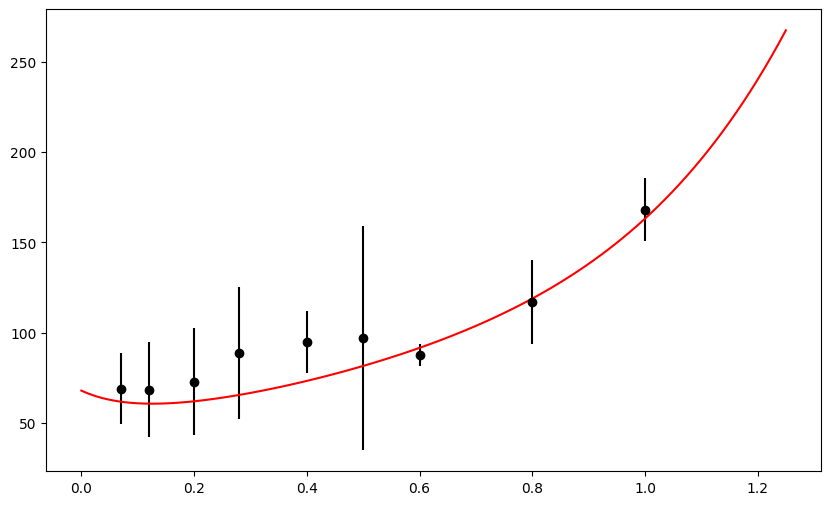

In [77]:
z_plot = np.linspace(0, 1.25, 100)
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(z_H, H_obs, yerr=H_err, fmt="o", color="black", label="Observational Data")
plt.plot(z_plot, H(z_plot, best_solution[0], best_solution[1]), color="red", label="Best Fit")